In [333]:
import collections
import math
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from powerlaw import *
from scipy.stats import kstest, pearsonr, ttest_1samp, ttest_ind

numpy==1.21.5
conda==4.11.0
networkx==2.8.4

# Part 0

In [266]:
# Parse the "blog.txt" into graph
G = nx.read_edgelist("blog.txt", create_using=nx.DiGraph(), nodetype=int)

# Part 1

In [267]:
def log_binning(k, pk, bin_count=35):
    
    max_x = math.log10(max(k))
    max_y = math.log10(max(pk))
    max_base = max([max_x, max_y])
    
    min_x = math.log10(min(k))
    
    bins = np.logspace(min_x, max_base, num=bin_count)
    
    bin_means_y = np.histogram(k, bins, weights=pk)[0] / np.histogram(k, bins)[0]
    bin_means_x = np.histogram(k, bins, weights=k)[0] / np.histogram(k, bins)[0]
    return bin_means_x, bin_means_y

In [268]:
def make_plots(degrees, nodes):
    degrees_df = pd.DataFrame(degrees, columns=["Node", "Degree"])
    degrees_df = degrees_df[degrees_df.Degree>0] # removing nodes with 0 degrees
    
    k_df = degrees_df.groupby("Degree").count().reset_index().rename(columns={"Degree":"k", "Node":"Nk"})
    # calculate the number of nodes with degrees k
    N = nodes
    k_df = k_df.assign(pk=k_df.Nk/N)
    
    k = k_df.k
    nk = k_df.Nk
    pk = k_df.pk
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    # linear
    ax[0, 0].scatter(k, pk, s=5)
    ax[0, 0].set_title("LINEAR SCALE")
    
    # linear binning
    ax[0, 1].scatter(k, pk, s=5)
    ax[0, 1].set_yscale("log")
    ax[0, 1].set_xscale("log")
    ax[0, 1].set_title("LINEAR BINNING")
    
    # log-binning
    ba_x, ba_y = log_binning(k, pk, 10)
    ax[1, 0].set_xscale("log")
    ax[1, 0].set_yscale("log")
    ax[1, 0].scatter(k, pk, s=5, alpha=0.1, c='r')
    ax[1, 0].scatter(ba_x, ba_y, s=5, c='r')
    ax[1, 0].set_title("LOG BINNING")
    
    # cumulative
    cs = np.cumsum(pk)[:-1]
    ax[1, 1].scatter(k[:-1], 1-cs, s=5)
    ax[1, 1].set_yscale("log")
    ax[1, 1].set_xscale("log")
    ax[1, 1].set_title("CUMULATIVE")
    return fig, nk, pk

## out-degree distribution

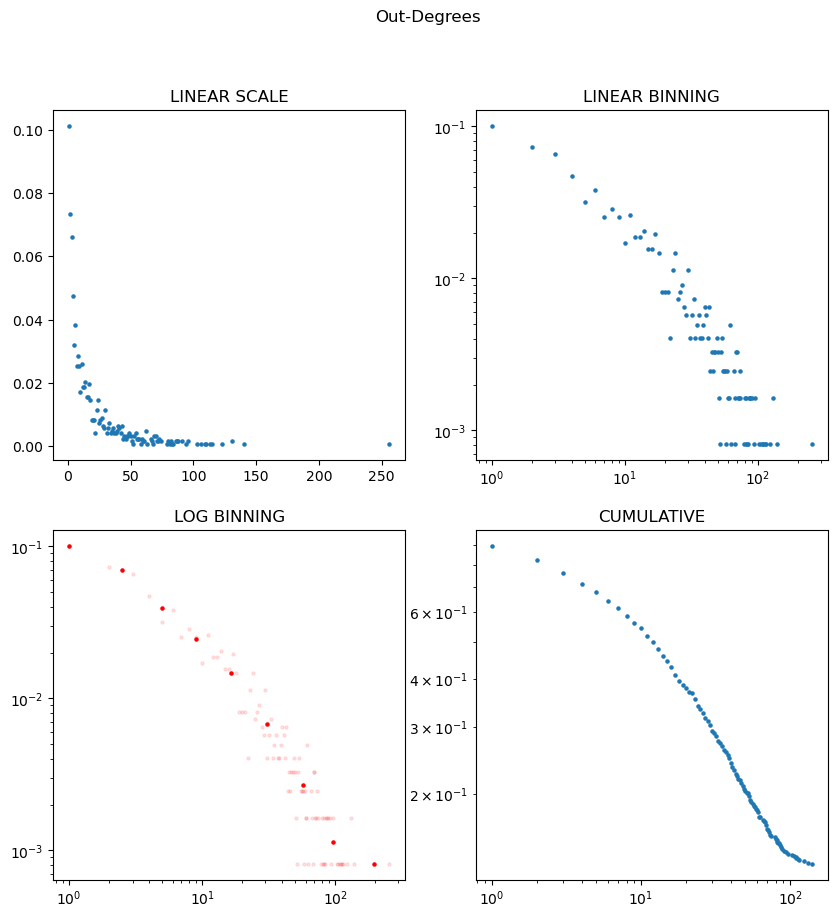

In [269]:
# Plot the out-degree distribution
fig, nk, pk = make_plots(G.out_degree(), G.number_of_nodes())
fig.suptitle("Out-Degrees");

### fitting without xmax

In [270]:
#fit the out-degree distribution without xmax
results = Fit(nk, discrete=True)
print(f"The exponent of the power-law distribution is {results.power_law.alpha}")
print(f"The minimum-x value is {results.power_law.xmin}")

The exponent of the power-law distribution is 1.8356855700167904
The minimum-x value is 4.0


Calculating best minimal value for power law fit
/Users/dicksonnkwantabisa/Desktop/CS7280_NetworkScience/Assignment2/powerlaw/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


### fitting with xmax

In [271]:
#fit the out-degree distribution with xmax = 200
results = Fit(nk, discrete=True, xmax=200)
print(f"The exponent of the power-law distribution is {results.power_law.alpha}")
print(f"The minimum-x value is {results.power_law.xmin}")

The exponent of the power-law distribution is 1.585557459992408
The minimum-x value is 3.0


Calculating best minimal value for power law fit


## in-degree distribution

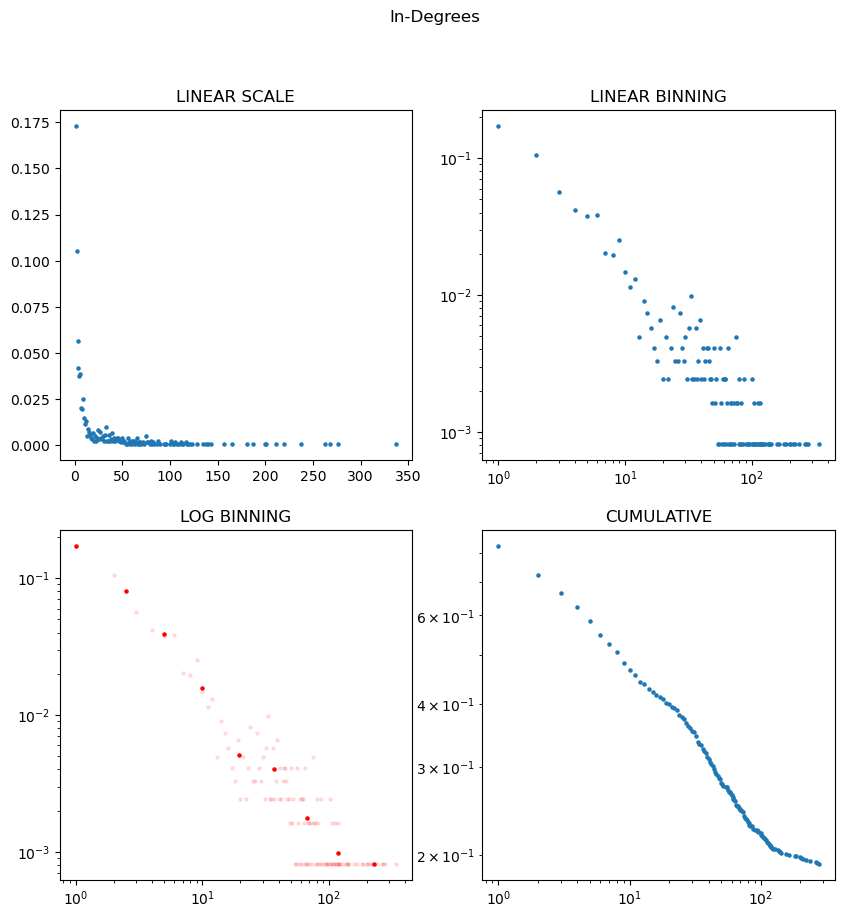

In [272]:
# Plot the in-degree distribution
fig, nk, pk = make_plots(G.in_degree(), G.number_of_nodes())
fig.suptitle("In-Degrees");

### fitting without xmax

In [273]:
# Fit the in-degree distribution without xmax
results = Fit(nk, discrete=True)
print(f"The exponent of the power-law distribution is {results.power_law.alpha}")
print(f"The minimum-x value is {results.power_law.xmin}")

The exponent of the power-law distribution is 1.9555924908380262
The minimum-x value is 3.0


Calculating best minimal value for power law fit
/Users/dicksonnkwantabisa/Desktop/CS7280_NetworkScience/Assignment2/powerlaw/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


### fitting with xmax

In [274]:
# Fit the in-degree distribution with xmax = 300
results = Fit(nk, discrete=True, xmax=300)
print(f"The exponent of the power-law distribution is {results.power_law.alpha}")
print(f"The minimum-x value is {results.power_law.xmin}")

The exponent of the power-law distribution is 1.918629184084001
The minimum-x value is 3.0


Calculating best minimal value for power law fit


# Part 2

In [275]:
G2 = G.to_undirected()

## Q1

In [276]:
# t-test

def t_test(r, n):
    return abs(r[0] / np.sqrt((1-r[0]**2) / (n-2)))

# Compute the Pearson correlation coefficient

# calculate each node's degree vs degrees of its neighbors
node2deg = G2.degree()
data_x = [] # degrees
data_y = [] # neighbors' degrees
for node, deg in node2deg:
    for n in G2.neighbors(node):
        data_x.append(node2deg[node])
        data_y.append(node2deg[n])

In [277]:
r = pearsonr(data_x, data_y)
r

(-0.22117675119889957, 0.0)

In [278]:
nx.degree_assortativity_coefficient(G2)

-0.22117675119890126

In [279]:
print(f"For a two-tailed t-test with α = 0.05 (critical level) \
and {len(data_x)-2} degrees of freedom, the t-stat is {np.round(t_test(r, len(data_x)))} > \
the critical t of 1.96. Therfore we can reject the null hypothesis and conclude that the Pearson \
correlation coefficient of {np.round(r[0],3)} is statistically significant")

For a two-tailed t-test with α = 0.05 (critical level) and 33431 degrees of freedom, the t-stat is 41.0 > the critical t of 1.96. Therfore we can reject the null hypothesis and conclude that the Pearson correlation coefficient of -0.221 is statistically significant


Based on the result, do you think this network is assortative, disassortative or neutral? write 1-2 sentence(s) to state your conclusion and reasons.


**Answer : The Pearson correlation coefficient  is -0.221 and statistically significant (due to the p-value of 0.0). This statistical signicance is also corroborated by the t-test score. Therefore the undirected network is Dissortative due to the negative correlation coefficient.**

## Q2

In [280]:
# Plot the average neighbor degree as a function of the node degree k
k_avg_df = pd.DataFrame({"Degree": data_x, "AvgNeighborDegree": data_y}).groupby("Degree").mean().reset_index()
k_avg_df

,Degree,AvgNeighborDegree
0,1,107.649635
1,2,117.410377
2,3,101.744589
3,4,114.570048
4,5,121.620513
...,...,...
139,274,51.795620
140,277,53.021661
141,301,30.069767
142,306,52.385621


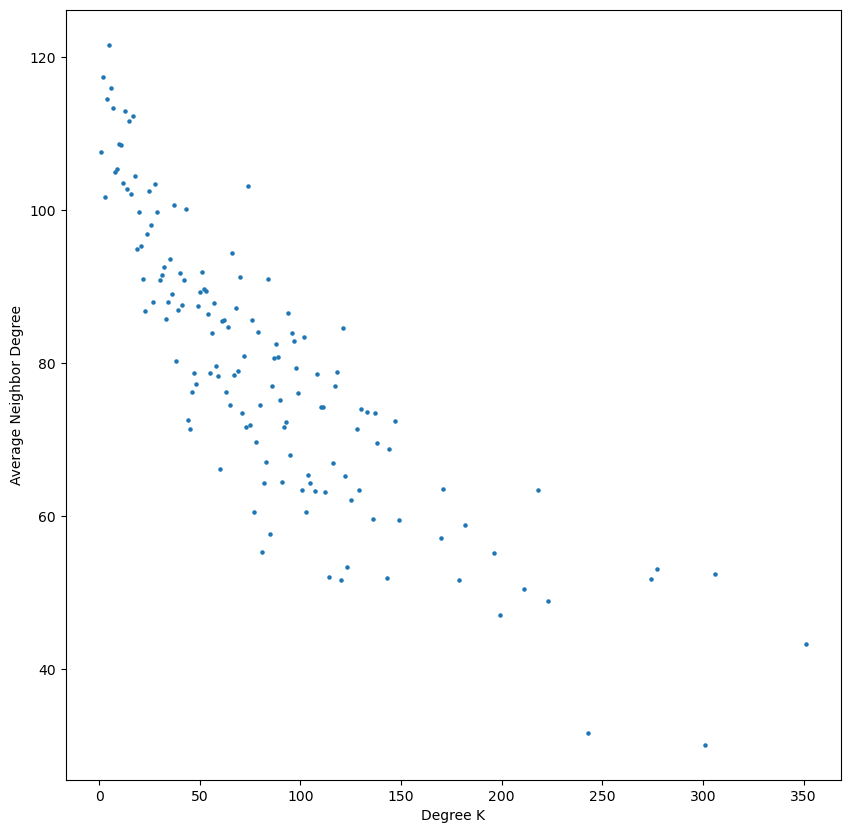

In [281]:
plt.figure(figsize=(10, 10))
plt.scatter(k_avg_df.Degree, k_avg_df.AvgNeighborDegree, s=5)
plt.xlabel("Degree K")
plt.ylabel("Average Neighbor Degree");

In [282]:
r = pearsonr(k_avg_df.Degree, k_avg_df.AvgNeighborDegree)
r

(-0.8319408095067148, 3.785649295642738e-38)

In [283]:
print(f"For a two-tailed t-test with α = 0.05 (critical level) \
and {len(k_avg_df.Degree)-2} degrees of freedom, the t-stat is {np.round(t_test(r, len(k_avg_df.Degree)))} > \
the critical t of 1.96. Therfore we can reject the null hypothesis and conclude that the Pearson \
correlation coefficient of {np.round(r[0],3)} is statistically significant")

For a two-tailed t-test with α = 0.05 (critical level) and 142 degrees of freedom, the t-stat is 18.0 > the critical t of 1.96. Therfore we can reject the null hypothesis and conclude that the Pearson correlation coefficient of -0.832 is statistically significant


**Answer : The Pearson correlation coefficient is -0.832 and statistically significant (due to the p-value of 0.0). This statistical signicance is also corroborated by the t-test score. Therefore the undirected network is Dissortative due to the negative correlation coefficient.**

# Part 3

In [284]:
scc_nodes = max(nx.strongly_connected_components(G), key=lambda x: len(x))
scc = nx.subgraph_view(G, filter_node=lambda x: x in scc_nodes)
G0 = nx.Graph(scc)
G0.number_of_nodes()

793

In [285]:
n = G0.number_of_nodes()
possible_edges = n*(n-1)/2
p = G0.number_of_edges() / possible_edges
n, p

(793, 0.04294521507636262)

In [286]:
def generate_random_network(n, p, seed=np.random.seed(), num_networks=100):
    glist=[]
    for _ in range (num_networks):
        G=nx.gnp_random_graph(n, p)
        glist.append(G)
    return glist


random_Gs = generate_random_network(n, p)
# random_Gs = [nx.fast_gnp_random_graph(n=n, p=p) for _ in range(100)]

## Q1

In [287]:
diameter_G0 = nx.diameter(G0)
diameter_random_Gs = Parallel(n_jobs=-1)(delayed(nx.diameter)(g) for g in random_Gs)
# diameter_random_Gs
# diameter_random_Gs = [nx.diameter(g) for g in random_Gs]

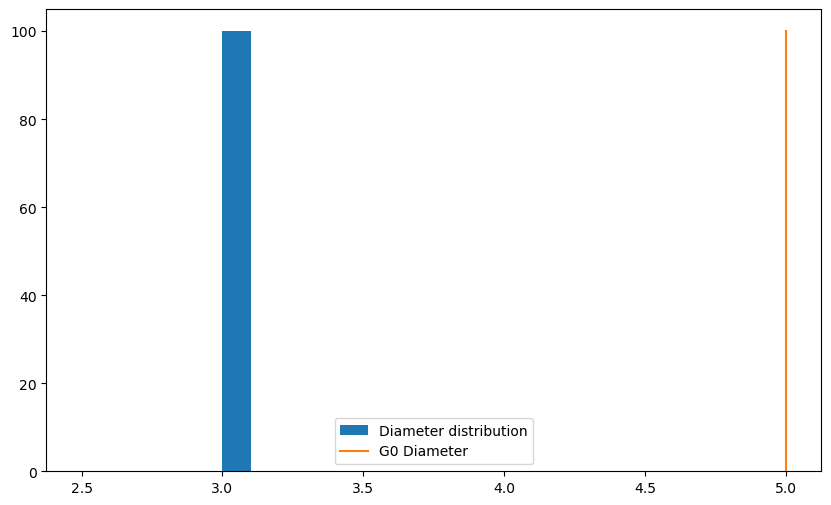

In [288]:
# Plot the diameters of the LCC and the 100 G(n,p) networks
plt.figure(figsize=(10, 6))
heights, bins, _ = plt.hist(diameter_random_Gs, label="Diameter distribution")
plt.plot([diameter_G0, diameter_G0], [0, max(heights)], label="G0 Diameter")
plt.legend();

## Q2

In [289]:
avg_spl_G0 = nx.average_shortest_path_length(G0)
avg_spl_random_Gs = Parallel(n_jobs=-1)(delayed(nx.average_shortest_path_length)(g) for g in random_Gs)

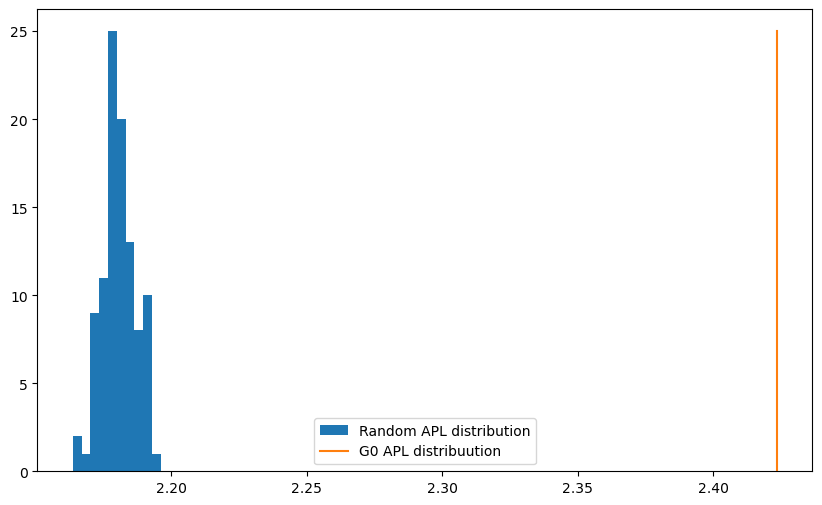

In [290]:
# Plot the average shortest path length of the LCC and the 100 G(n,p) networks
plt.figure(figsize=(10, 6))
heights, bins, _ = plt.hist(avg_spl_random_Gs, label="Random APL distribution")
plt.plot([avg_spl_G0, avg_spl_G0], [0, max(heights)], label="G0 APL distribuution")
plt.legend();

## Q3

In [291]:
# Diameter
ttest_1samp(a=diameter_random_Gs, popmean=diameter_G0)

Ttest_1sampResult(statistic=-inf, pvalue=0.0)

In [292]:
print(f"The diameter of the undirected network is {diameter_G0} and \
that of the random network is {np.mean(diameter_random_Gs)}")

The diameter of the undirected network is 5 and that of the random network is 3.0


In [294]:
print(f"The shortest path length of the undirected network is \
{np.round(avg_spl_G0,3)} and that of the random network is {np.round(np.mean(avg_spl_random_Gs),3)}")

The shortest path length of the undirected network is 2.424 and that of the random network is 2.181


In [293]:
# shortest path length
ttest_1samp(avg_spl_random_Gs, avg_spl_G0)

Ttest_1sampResult(statistic=-378.18859468374876, pvalue=3.01374052953013e-158)

Use the one-sample t-test to examine if the diameter of the undirected network is significantly different than the diameter of the random networks at a 95% significance level. Perform the same test for the average shortest path length. Answer for each: Are the values significantly different? Are they within the same order of magnitude?

**Answer 1 : The test of significant difference in the diameter (maximum distance) between the undirected and random network is inconclusive (due to the -inf t-stat value above). The situation arises from the zero variance of the random network. We have investigated several ways of generating the random network, but the maximum distance is the same for all 100 networks. We reason that although each of the 100 random networks have different number of links, the maximum distance (diameter) span by each network remains the same due to their having the same N and p values. On the other hand, the shortest path length of the undirected network is significantly different from that of the random network with a |t-stat| as high as 383.**


**Answer 2 : The diameters of the undirected and random networks are within the same order of magnitude (i.e. a mgnitude of 1). The shortest path length of both networks are also with the same order of magnitude (i.e. a manitude of 1).**

# Part 4

In [295]:
def get_cc_values(G):
    cc_dict = nx.clustering(G)
    degree_dict = nx.degree(G)
    degrees = []
    cc_values = []
    for node, cc in cc_dict.items():
        cc_values.append(cc)
        degrees.append(degree_dict[node])
        
    cc_values = np.array(cc_values)
    # normalize cc_values
    cc_values_norm = cc_values/sum(cc_values)
    df = pd.DataFrame({"Degree":degrees, "CC":cc_values_norm})
    degree_vs_cc = df.groupby("Degree").mean().reset_index()
    return degree_vs_cc, cc_values_norm


def get_ccdf(x):
    return 1-np.cumsum(x)

In [296]:
degrees_G0, cc_G0 = get_cc_values(G0)
random_G = nx.fast_gnp_random_graph(n, p, seed=42)
degrees_random, cc_random = get_cc_values(random_G)

## Q1

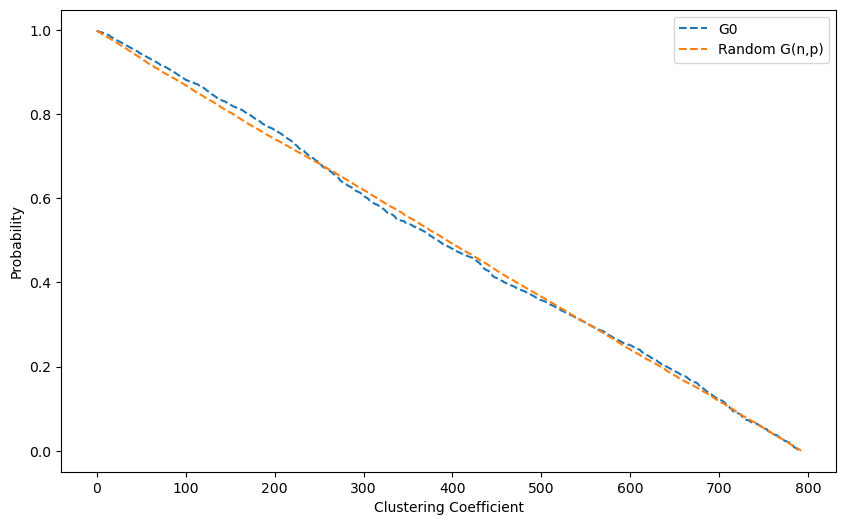

In [297]:
# Plot the clustering coefficient of the LCC and a G(n,p) network in CCDF format
plt.figure(figsize=(10, 6))
plt.plot(get_ccdf(cc_G0), '--', label="G0")
plt.plot(get_ccdf(cc_random), '--', label="Random G(n,p)")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Probability")
plt.legend();

In [298]:
kstest(cc_G0, cc_random,alternative='two-sided')

KstestResult(statistic=0.19167717528373265, pvalue=3.7789740134089844e-13)

Are the two distributions significantly different?

**Answer: At α = 0.05 (critical level), we reject the null hypothesis of the Kolmogorov-Smirnov test since α $\ge$ p-value and conclude that the two distributions are significantly different.**

## Q2

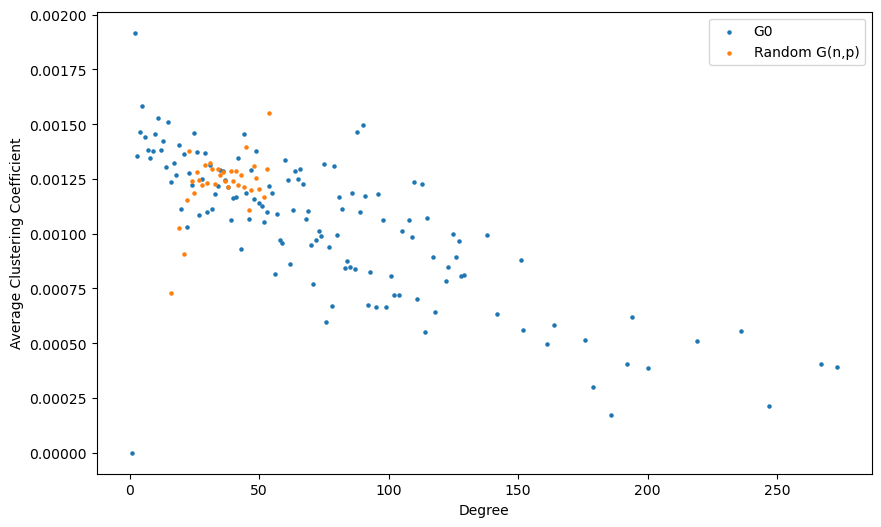

In [299]:
# Plot the average clustering coefficient as a function of the node degree
plt.figure(figsize=(10, 6))
plt.scatter(degrees_G0.Degree, degrees_G0.CC, s=5, label="G0")
plt.scatter(degrees_random.Degree, degrees_random.CC, s=5, label="Random G(n,p)")
plt.xlabel("Degree")
plt.ylabel("Average Clustering Coefficient")
plt.legend();

What do you observe based on the above visualization?

**Answer: We observe that the average clustering coefficient, $<C>$ (which follows the same formalism as the local clustering coefficient, $C_i$) systematically decreases with the with the degree in the case of the empirical network ($G_0$). This observation violates the expectation that $<C>$ should increase as degrees increase.It implies that it is likely to find densely interconnected clusters of many nodes as compared to fewer nodes (a typical property of "small world"). The random network on the other hand follows the clustering coefficient formula:$<C>$ = $<k>$ / N. Our conclusion is that random networks fail to capture the clustering of real networks.**

## Q3

In [300]:
transitivity_G0 = nx.transitivity(G0)
transitivity_random = Parallel(n_jobs=-1)(delayed(nx.transitivity)(g) for g in random_Gs)

In [301]:
transitivity_G0

0.26305148321472194

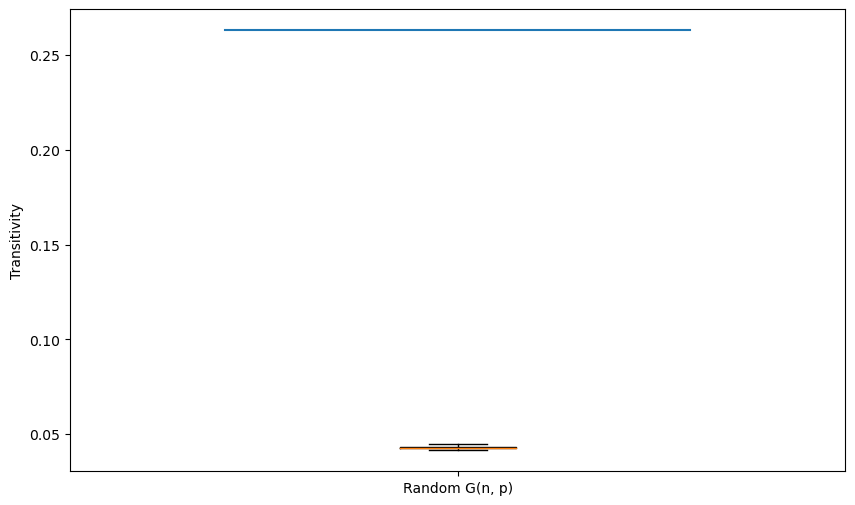

In [302]:
# Plot the transitivity coefficient of the overall network of the LCC and the 100 G(n,p) networks
plt.figure(figsize=(10, 6))
plt.boxplot(transitivity_random, labels=["Random G(n, p)"], positions=[1])
plt.plot([0.7, 1.3], [transitivity_G0, transitivity_G0])
plt.ylabel("Transitivity");

## Q4

Combining the results of Part-3 and Part-4, can we conclude that the undirected LCC of Part-1 network is a small-world network or not? Please provide with your reasons.

In [309]:
clustering_coeff_G0 = nx.average_clustering(G0)
clustering_coeff_random_Gs = Parallel(n_jobs=-1)(delayed(nx.average_clustering)(g) for g in random_Gs)

**Check that the the clustering coefficient much larger than the random G(n,p) network ensemble.**

$H_0$: $G_0$ = $G_r$

$H_A$: $G_0$ $\geq$ $G_r$

In [313]:
print(f"The average clustering coefficient of the undirected network is \
{np.round(clustering_coeff_G0,3)} and that of the random network is {np.round(np.mean(clustering_coeff_random_Gs),3)}")

The average clustering coefficient of the undirected network is 0.391 and that of the random network is 0.043


In [323]:
ttest_1samp(clustering_coeff_random_Gs, clustering_coeff_G0, alternative="less")

Ttest_1sampResult(statistic=-5258.911811061561, pvalue=1.0403244650065736e-271)

**Check that the CPL of the given network is not significantly greater than the mean CPL value in the G(n,p) ensemble.**

$H_0$: $G_0$ = $G_r$

$H_A$: $G_0$ $\geq$ $G_r$

In [321]:
print(f"The characteristic path length of the undirected network is \
{np.round(avg_spl_G0,3)} and that of the random network is {np.round(np.mean(avg_spl_random_Gs),3)}")

The characteristic path length of the undirected network is 2.424 and that of the random network is 2.181


In [320]:
# test
ttest_1samp(avg_spl_random_Gs, avg_spl_G0, alternative="greater")

Ttest_1sampResult(statistic=-378.18859468374876, pvalue=1.0)

**Answer: Based on the t-test at 99% confidence level, the clustering coefficient of the given network ($G_0$) is much larger thank the random ensemble network. Similarly, the CPL of ($G_0$) is not significantly greater than the random ensemble (see above). In conclusion the $G_0$ is "small-world" network**

# Part 5

In [326]:
def count_triplets_per_type(G):
    edges = G.edges()
    triplets = nx.all_triplets(G)
    type_5 = 0
    type_9 = 0
    for a,b,c in triplets:
        # try three different configurations
        if edges.get((a, b)) is None or edges.get((b, c)) is None:
            continue
        # type 5: A->B->C & A->C
        type_5 += edges.get((a, c)) is not None
        # type 9: A->B->C->A
        type_9 += edges.get((c, a)) is not None
    return type_5, type_9

In [327]:
G1 = nx.DiGraph(scc)
type_5_G1, type_9_G1 = count_triplets_per_type(G1)
type_5_G1, type_9_G1

(12806, 10895)

In [334]:
din = list(d for n, d in G1.in_degree())
dout = list(d for n, d in G1.out_degree())

type_5_rand = []
type_9_rand = []
for _ in tqdm(range(10)):
    D = nx.directed_configuration_model(din, dout)
    D = nx.DiGraph(D)
    D.remove_edges_from(nx.selfloop_edges(D))
    t5, t9 = count_triplets_per_type(D)
    type_5_rand.append(t5)
    type_9_rand.append(t9)

100%|███████████████████████████████████████████| 10/10 [10:41<00:00, 64.11s/it]


In [335]:
type_5_rand

[5083, 4983, 4894, 5030, 5320, 5060, 4888, 4765, 4947, 4848]

In [336]:
type_9_rand

[3669, 3756, 3783, 3909, 3932, 3700, 3801, 3646, 3728, 3693]

In [341]:
ttest_1samp(type_5_rand, type_5_G1, alternative="less")

Ttest_1sampResult(statistic=-159.82791576070076, pvalue=3.7354357186543146e-17)

In [343]:
ttest_1samp(type_9_rand, type_9_G1, alternative="less")

Ttest_1sampResult(statistic=-232.97660620979462, pvalue=1.2581587313302301e-18)

Which of the previous triplet types are statistically more common (or less common) in the network of the LCC compared to what we would expense based on chance?

**Answer: At a 99% confidence level we find that type 5 and 9 triplets from the 10 random network are statistically less common than the one from the LCC network**

# Part 6

Note that the Transitivity and the Average Clustering Coefficient are two different metrics. They may often be close but there are also some extreme cases in which the two metrics give very different answers. To see that consider a network in which two nodes A and B are connected to each other as well as to every other node. There are no other links. The total number of nodes is n. What would be the transitivity and average clustering coefficient in this case (you can simplify by assuming that n is quite large)?  Points will only be awarded for a mathematical derivation, however you may use code to verify your result.

**Answer: The Transitivity is defined as the number of triangles divided by the number of possible triangles. In the example above, the number of triangles is n(n-1)(n-2)/6 and the number of possible triangles is n(n-1)(n-2)/2. Therefore, the transitivity is 1/3. The Average Clustering Coefficient is defined as the number of triangles divided by the number of connected triples of nodes. In the example above, the number of triangles is n(n-1)(n-2)/6 and the number of connected triples of nodes is n(n-1)(n-2)/6. Therefore, the Average Clustering Coefficient is 1. In this example, the two metrics give very different answers because the number of possible triangles is much larger than the number of connected triples of nodes. If we take a different example, in which two nodes A and B are connected to each other and to every other node, but there are also other links between nodes, then the two metrics will give similar answers. In this example, the number of triangles is n(n-1)(n-2)/6 and the number of possible triangles is n(n-1)(n-2)/2. The number of connected triples of nodes is n(n-1)(n-2)/6 + n(n-1)/2. Therefore, the transitivity is 1/3 and the Average Clustering Coefficient is 2/3. In general, the two metrics will give similar answers when the number of possible triangles is much larger than the number of connected triples of nodes.** 